# Tutorail on Enumeration of Cartesian Products in Pyro

### Import the necessary modules

In [1]:
import os
import torch
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True) 

### Normal approach (i.e. no enumeration)

Note that:
1. in Trace_ELBO we draw "num_particles" samples.
2. the configuration which is drawn has the shape "BATCH x N_BOXES", i.e. both batch and dependent dimensions are expanded

In [2]:
def model():
    p = 0.1*torch.Tensor([[1,2,3,4], [5,5,5,5], [7,7,7,7]])
    with pyro.iarange('batch', 3):
        values = []
        for i in pyro.irange('n_boxes', 4):
            s = pyro.sample('box_%d' % i, dist.Bernoulli(probs=p[:,i]))
            values.append(s)
        config = torch.stack(values, dim=1)
        
def guide():
    p = 0.1*torch.Tensor([[1,2,3,4], [5,5,5,5], [7,7,7,7]])
    with pyro.iarange('batch', 3):
        values = []
        for i in pyro.irange('n_boxes', 4):
            s = pyro.sample('box_%d' % i, dist.Bernoulli(probs=p[:,i]))
            values.append(s)
        config = torch.stack(values, dim=1)
        print("config_normal:",config.shape,config)
        
elbo = Trace_ELBO(max_plate_nesting=1,num_particles=2)
elbo.loss(model,guide);

print("------------------")
print("Debug normal model")
trace = poutine.trace(model).get_trace()
trace.compute_log_prob()  
print(trace.format_shapes())

config_normal: torch.Size([3, 4]) tensor([[0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 0.]])
config_normal: torch.Size([3, 4]) tensor([[0., 0., 1., 0.],
        [0., 1., 1., 1.],
        [1., 0., 1., 1.]])
------------------
Debug normal model
Trace Shapes:    
 Param Sites:    
Sample Sites:    
   batch dist   |
        value 3 |
     log_prob   |
 n_boxes dist   |
        value 4 |
     log_prob   |
   box_0 dist 3 |
        value 3 |
     log_prob 3 |
   box_1 dist 3 |
        value 3 |
     log_prob 3 |
   box_2 dist 3 |
        value 3 |
     log_prob 3 |
   box_3 dist 3 |
        value 3 |
     log_prob 3 |


### Sequential enumeration

Note that:
1. we use TraceEnum_ELBO with max_plate_nesting=1 
2. we could add "num_particles" to draw more samples. This make ssense only if we have both enumerated and sampled variables.
3. the guide generates 2^(N_BOXES) configurations of shape "1 x N_BOXES", i.e. we do NOT enumerate over the bathc dimension

In [3]:
def model_seq():
    p = 0.1*torch.Tensor([[1,2,3,4], [5,5,5,5], [7,7,7,7]])
    with pyro.iarange('batch', 3):
        values = []
        for i in pyro.irange('n_boxes', 4):
            s = pyro.sample('box_%d' % i, dist.Bernoulli(probs=p[:,i]),infer={"enumerate": "sequential"})
            values.append(s)
        config = torch.stack(values, dim=1)
        
def guide_seq():
    p = 0.1*torch.Tensor([[1,2,3,4], [5,5,5,5], [7,7,7,7]])
    with pyro.iarange('batch', 3):
        values = []
        for i in pyro.irange('n_boxes', 4):
            s = pyro.sample('box_%d' % i, dist.Bernoulli(probs=p[:,i]),infer={"enumerate": "sequential"})
            values.append(s)
        config = torch.stack(values, dim=1)
        print("config_seq:",config.shape,config)
        
elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_seq,guide_seq);      

print("----------------------")
print("Debug sequential model")
trace = poutine.trace(model_seq).get_trace()
trace.compute_log_prob()  
print(trace.format_shapes())

config_seq: torch.Size([1, 4]) tensor([[1., 1., 1., 1.]])
config_seq: torch.Size([1, 4]) tensor([[1., 1., 1., 0.]])
config_seq: torch.Size([1, 4]) tensor([[1., 1., 0., 1.]])
config_seq: torch.Size([1, 4]) tensor([[1., 1., 0., 0.]])
config_seq: torch.Size([1, 4]) tensor([[1., 0., 1., 1.]])
config_seq: torch.Size([1, 4]) tensor([[1., 0., 1., 0.]])
config_seq: torch.Size([1, 4]) tensor([[1., 0., 0., 1.]])
config_seq: torch.Size([1, 4]) tensor([[1., 0., 0., 0.]])
config_seq: torch.Size([1, 4]) tensor([[0., 1., 1., 1.]])
config_seq: torch.Size([1, 4]) tensor([[0., 1., 1., 0.]])
config_seq: torch.Size([1, 4]) tensor([[0., 1., 0., 1.]])
config_seq: torch.Size([1, 4]) tensor([[0., 1., 0., 0.]])
config_seq: torch.Size([1, 4]) tensor([[0., 0., 1., 1.]])
config_seq: torch.Size([1, 4]) tensor([[0., 0., 1., 0.]])
config_seq: torch.Size([1, 4]) tensor([[0., 0., 0., 1.]])
config_seq: torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
----------------------
Debug sequential model
Trace Shapes:    
 Param S

### Parallel enumeration

Note that:
1. we use TraceEnum_ELBO with max_plate_nesting=1 
2. we could add "num_particles" to draw more samples. This make ssense only if we have both enumerated and sampled variables.
3. the guide generates a tensor of size 2 x ... x 1 for each box variable. To obtain the enumeration over the cartesian space you need to multiply the tensors. This is possible b/c the size are brodcastasble.
4. Parallel enumeration makes sense if there are "obs" statement that depend on some only on some of the variables. If the "obs" statement depends on the complete enumeration it make sense to use sequential numeration instead.

In [4]:
def model_par():
    p = 0.1*torch.Tensor([[1,2,3,4], [5,5,5,5], [7,7,7,7]])
    with pyro.iarange('batch', 3):
        values = []
        for i in pyro.irange('n_boxes', 4):
            s = pyro.sample('box_%d' % i, dist.Bernoulli(probs=p[:,i]),infer={"enumerate": "parallel"})
            values.append(s)
        #config = torch.stack(values, dim=1)
        
def guide_par():
    p = 0.1*torch.Tensor([[1,2,3,4], [5,5,5,5], [7,7,7,7]])
    with pyro.iarange('batch', 3):
        values = []
        p_boxes = torch.ones(1)
        for i in pyro.irange('n_boxes', 4):
            s = pyro.sample('box_%d' % i, dist.Bernoulli(probs=p[:,i]),infer={"enumerate": "parallel"})
            values.append(s)
            p_boxes = p_boxes * s
            print("s -> ",s.shape,s)
        print("p_boxes.shape",p_boxes.shape)

elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_par,guide_par);

print("--------------------")
print("Debug parallel model")    
trace = poutine.trace(poutine.enum(model_par, first_available_dim=-2)).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

s ->  torch.Size([2, 1]) tensor([[0.],
        [1.]])
s ->  torch.Size([2, 1, 1]) tensor([[[0.]],

        [[1.]]])
s ->  torch.Size([2, 1, 1, 1]) tensor([[[[0.]]],


        [[[1.]]]])
s ->  torch.Size([2, 1, 1, 1, 1]) tensor([[[[[0.]]]],



        [[[[1.]]]]])
p_boxes.shape torch.Size([2, 2, 2, 2, 1])
--------------------
Debug parallel model
Trace Shapes:            
 Param Sites:            
Sample Sites:            
   batch dist           |
        value         3 |
     log_prob           |
 n_boxes dist           |
        value         4 |
     log_prob           |
   box_0 dist         3 |
        value       2 1 |
     log_prob       2 3 |
   box_1 dist         3 |
        value     2 1 1 |
     log_prob     2 1 3 |
   box_2 dist         3 |
        value   2 1 1 1 |
     log_prob   2 1 1 3 |
   box_3 dist         3 |
        value 2 1 1 1 1 |
     log_prob 2 1 1 1 3 |


## Try the real deal

It is extremely important that the enumerate variables are last.
This is b/c in pyro if "a" follows "b" then "b" might depend on "a".

In [5]:
def model_and_guide():
            
    batch_size = 3
    N_DAPI_MAX = 4
    Zwhat_dim = 50
    p = torch.rand((batch_size,N_DAPI_MAX,1))
    
    with pyro.iarange('batch', batch_size):
        
        z = pyro.sample("latent_z",dist.Normal(0,1).expand([N_DAPI_MAX,Zwhat_dim]).to_event(2))
        print("z",z.shape,z[:,:,12])
        
        # Sample the c values at the end
        values = []
        for i in pyro.irange('n_boxes', N_DAPI_MAX):
            c = pyro.sample('box_%d' % i, dist.Bernoulli(probs=p[:,i,0]),infer={"enumerate": "sequential"})
            values.append(c)
        config = torch.stack(values, dim=1)
        print("config:",config.shape,config)
        


elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_and_guide,model_and_guide);

print("--------------------")
print("Debug real model")    
trace = poutine.trace(model_and_guide).get_trace()
trace.compute_log_prob()  
print(trace.format_shapes())

z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
config: torch.Size([1, 4]) tensor([[1., 1., 1., 1.]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [

config: torch.Size([1, 4]) tensor([[0., 0., 0., 1.]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
config: torch.Size([1, 4]) tensor([[0., 0., 0., 1.]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
config: torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
z torch.Size([3, 4, 50]) tensor([[ 0.6550,  0.5389,  0.0536,  0.4080],
        [ 0.2538,  1.3784, -0.5017, -1.5882],
        [ 0.0999, -0.1163,  0.2889,  0.7559]])
config: torch.Size([1, 4]) tensor([[0., 0., 0., 0.]])
--------------------
Debug real model
z torch.Size([3, 4, 50]) tensor([[-1.2063, -0.3114, -0.4207, -0.7088],
        [-1.4023, -1.2109, -0.1666, -2.0044],
        [ 0.0248, -1.2643, -1.7743, -0.0443]])
config: torch.Size([3, 4]) tensor([[1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [0.

### VAE CLASS

In [6]:
class Compositional_VAE(torch.nn.Module):
    
    def __init__(self, params,inference,generator):
        super().__init__()
        
        # Instantiate the encoder and decoder
        self.inference = inference
        self.generator = generator
        
        # Parameters
        self.single_image_dim = params['SD.dim_output']
        self.EPS_UNIFORM = params['safety_uniform_dist']   
        self.x_uniform_dist = 1.0+self.EPS_UNIFORM 
        self.N_DAPI_MAX = params['YOLO.N_dapi_max']
        self.Zwhere_dim = params['UNET.Zwhere_dim']
        self.Zwhat_dim  = params['UNET.Zwhat_dim']
        self.N_DAPI_EXPECTED = params['expected_number_of_cells']
        self.p_bernulli = float(self.N_DAPI_EXPECTED)/self.N_DAPI_MAX
        bb_average = 2.0*params['bb_average_UNET_grid'] / params['UNET.W_coarsest']
        print("Debug bb_avergae",bb_average)
        bb_std = bb_average*params['bb_std_over_mean']
        bb_var = bb_std*bb_std
        self.bb_gamma_beta  = bb_average/bb_var
        self.bb_gamma_alpha = bb_average*self.bb_gamma_beta
        print("Debug alpha,beta",self.bb_gamma_alpha,self.bb_gamma_beta)
           
        # Put everything on the cude if necessary
        self.use_cuda = params["use_cuda"]
        if self.use_cuda:
            self.cuda()  
    
      
    def model(self, imgs=None):
        """ 1.  sample the latent from the prior:
            2.  runs the generative model
            3.  return the generated image (and if actual data is passed score the generative model against it)
        """
        
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            W = self.generator.W_raw_image
            CH = self.generator.CH_raw_image 
            imgs = torch.zeros(8,CH,W,W)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        batch_size = imgs.shape[0]
        
        # This is a trick to have zeor and one written on the same device as the images
        zero = imgs.new_zeros(1)
        one = imgs.new_ones(1)
        p_bernulli = self.p_bernulli*one
        alpha = self.bb_gamma_alpha*one
        beta = self.bb_gamma_beta*one
        x_uniform_dist = self.x_uniform_dist*one
        # The center of the cell can be slightly outside the image, 
        # therefore I set the support of the distribution to (-1.1,1.1) 
        
        pyro.module("generator", self.generator)
        
        with pyro.plate("batch", batch_size, dim=-1):
            
            z = pyro.sample("latent_z",
                            dist.Normal(zero,one).expand([self.N_DAPI_MAX,self.Zwhat_dim]).to_event(2))

            cxcy = pyro.sample("center_bb",
                               dist.Uniform(-x_uniform_dist,x_uniform_dist).expand([self.N_DAPI_MAX,2]).to_event(2))
            dxdy = pyro.sample("size_bb",
                               dist.Gamma(alpha,beta).expand([self.N_DAPI_MAX,2]).to_event(2))
            
            # Probability of a cell
            values = []
            for i in pyro.irange('n_boxes', self.N_DAPI_MAX):
                c = pyro.sample('c_%d' % i, dist.Bernoulli(p_bernulli))
                values.append(c)
            c_cell = torch.stack(values, dim=1)
            c_config = c_cell.unsqueeze(2).expand(dxdy.shape[0],-1,-1)
            #print("c_config.shape",c_config.shape)
            assert((batch_size,self.N_DAPI_MAX,1)==c_config.shape)
            
            # Invert stuff for easier work by the generator
            sxsy = 2.0/dxdy
            kxky = -cxcy*sxsy  
            x_mu = self.generator.forward(c_config,sxsy,kxky,z,self.detach_single_dapi_decoder)
            
            if(observed):
                x_std = 0.1 * torch.ones_like(x_mu)
                pyro.sample("obs",dist.Normal(x_mu.view(-1,self.single_image_dim),x_std.view(-1,self.single_image_dim)).to_event(1),
                            obs=imgs.view(-1,self.single_image_dim))
            
            return x_mu,c_config,dxdy,cxcy
            
    def guide(self, imgs=None):
        """ The GUIDE takes a mini-batch of images and: 
            1. run the inference to get z_where,z_what
            encoder to get: p,sxsy_mu,kxky_mu,z_mu,z_std
            2. Compute cxcy_mu and dxdy_mu
            2. sample:
                - z ~ N(z_mu, z_std) where each component of z is drawn independently
                - c ~ Bernulli(p)
                - cxcy ~ N(cxcy_mu,0.1) 
                - dxdy ~ gamma(dxdy_mu,0.1) 
        """
        
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            W = self.generator.W_raw_image
            CH = self.generator.CH_raw_image 
            imgs = torch.zeros(8,CH,W,W)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True    
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
               
        batch_size = imgs.shape[0]            
        pyro.module("inference",self.inference)
        
        #--------------------------#
        #-- 1. run the inference --#
        #--------------------------#
        p,sxsy_mu,kxky_mu,z_mu,z_std = self.inference.forward(imgs)        
        
        # Transform stuff around for easier sampling
        dxdy_mu = 2.0/sxsy_mu      # size of the bounding box 
        cxcy_mu = torch.clamp(-kxky_mu/sxsy_mu, min=-self.x_uniform_dist, max=self.x_uniform_dist) 
                                  
        #---------------#    
        #-- 2. Sample --#
        #---------------#
        with pyro.plate("batch", batch_size, dim =-1 ):   
            
            # Latent z
            pyro.sample("latent_z",dist.Normal(z_mu, z_std).to_event(2))
            
            # Centers
            pyro.sample("center_bb",dist.Normal(cxcy_mu, 0.01*torch.ones_like(cxcy_mu)).to_event(2))
            
            # Size of bounding boxes
            alpha_dxdy = 100*torch.ones_like(dxdy_mu)
            beta_dxdy = alpha_dxdy / dxdy_mu
            pyro.sample("size_bb",dist.Gamma(alpha_dxdy, beta_dxdy).to_event(2)) 
            
            # Probability of a cell
            values = []
            for i in pyro.irange('n_boxes', self.N_DAPI_MAX):
                c = pyro.sample('c_%d' % i, dist.Bernoulli(probs=p[:,i,0]),infer={"enumerate": "sequential"})
                values.append(c)
            c_cell = torch.stack(values, dim=1)
            #print("c_cell:",c_cell.shape,c_cell)
                
                   
    def train_one_epoch(self, svi, train_loader, desired_channels,verbose):
        self.train()
        epoch_loss = 0.
        normalizer_train = 0.
        for i, x in enumerate(train_loader): #get the images
                      
            # set the number of channels to desired_channels
            B,CH,W,H = x.shape
            x = x.view(-1,desired_channels,W,H)
            normalizer_train += float(B*CH)/desired_channels
            
            # if on GPU put mini-batch into CUDA memory
            if self.use_cuda:
                x = x.cuda()
            loss = svi.step(x)
            if(verbose):
                print("i= %3d train_loss=%.5f" %(i,loss))
            epoch_loss += loss

        total_epoch_loss_train = epoch_loss / normalizer_train
        return total_epoch_loss_train

    def evaluate_one_epoch(self, svi, test_loader, desired_channels,verbose):
        self.eval()
        test_loss = 0.
        normalizer_test = 0.
        for i, x in enumerate(test_loader): #get the images
            
            # set the number of channels to desired_channels
            B,CH,W,H = x.shape
            x = x.view(-1,desired_channels,W,H)
            normalizer_test += float(B*CH)/desired_channels
            
            # if on GPU put mini-batch into CUDA memory
            if self.use_cuda:
                x = x.cuda()
            loss = svi.evaluate_loss(x)
            if(verbose):
                print("i= %3d test_loss=%.5f" %(i,loss))
            test_loss += loss

        total_epoch_loss_test = test_loss / normalizer_test
        return total_epoch_loss_test 
    
    
    def generate_synthetic_data(self, N=100):
        
        x_mu,c,dxdy,cxcy = self.model()
        BATCH, CH, W, H = x_mu.shape    
        synthetic_data = torch.zeros((N, CH, W, H), dtype=torch.float32, device='cpu', requires_grad=False) 
        
        l = 0 
        while (l<N):
            # Compute left and right indeces
            r = min(l+BATCH,N)
            d = r-l
            synthetic_data[l:r,:,:,:]=x_mu[0:d,:,:,:].detach().cpu()
            l = r
            x_mu,c,dxdy,cxcy = self.model()
        return synthetic_data
        

### Generate simulation parameters

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

from low_level_utility import DataSet_for_cell_segmentation, Synthetic_DataSet, dataloader, N_RandomCrop, show_batch 
from low_level_utility import overlay_image_and_unet_grid, save_model, save_obj, load_model, load_obj, test_model
from unet import partial_UNET, CNN_Net
from yolo import YOLO_filter
from dapi_generator import CompositionalGenerator
from simulation_dictionary import SimulationDictionary 
#from vae import Compositional_VAE

import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, Adamax, SGD
from torch.utils.data.dataset import Dataset
from torch.utils.data import TensorDataset




#### Create the simulation parameters dictionary
params=SimulationDictionary()

# Check the params              
params["expected_number_of_cells"]=0.9
print(params)


{'safety_uniform_dist': 0.1, 'expected_number_of_cells': 0.9, 'bb_average_UNET_grid': 1.0, 'bb_std_over_mean': 0.1, 'UNET.W_coarsest': 2, 'UNET.N_max_pool': 4, 'UNET.N_up_conv': 0, 'UNET.CH_after_first_two_conv': 8, 'UNET.N_prediction_maps': 1, 'UNET.Zwhat_dim': 50, 'UNET.Zwhere_dim': 5, 'UNET.CH_raw_image': 1, 'UNET.W_raw_image': 32, 'UNET.W_output': 2, 'SD.W': 32, 'SD.output_channel': 1, 'SD.dim_z': 50, 'SD.dim_output': 1024, 'SD.dim_h1': 400, 'SD.dim_h2': -1, 'YOLO.p_threshold': 0.0, 'YOLO.IoU_threshold': 0.2, 'YOLO.N_dapi_max': 4, 'device': device(type='cpu'), 'dtype': torch.float32, 'dtype_tensor': <class 'torch.FloatTensor'>, 'use_cuda': False}


### LOAD SYNTHETIC DATA

{'num_workers': 1, 'pin_memory': False}
{'num_workers': 1, 'pin_memory': False}
torch.Size([16, 1, 32, 32])


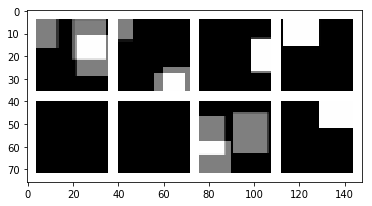

In [9]:
#BATCH_SIZE = 256
BATCH_SIZE = 16

synthetic_data_train = load_obj("synthetic_data_train_v4")  
synthetic_data_test = load_obj("synthetic_data_test_v4")  
            
kwargs = {'num_workers': 1, 'pin_memory': params["use_cuda"]}

train_data = Synthetic_DataSet(synthetic_data_train)
test_data  = Synthetic_DataSet(synthetic_data_test)
trainloader = dataloader(train_data,BATCH_SIZE,shuffle=True, **kwargs)
testloader =  dataloader(test_data,BATCH_SIZE,shuffle=False, **kwargs)

imgs=trainloader.load(CHANNELS=1)
show_batch(imgs[:8],nrow=4,npadding=4)
print(imgs.shape)

### Check UNET

In [10]:
#unet = CNN_Net(params)
#unet.show_receptive_field()

In [11]:
#image_and_grid = overlay_image_and_unet_grid(imgs[0],unet.W_list)
#L = int(image_and_grid.shape[0]/3)
#show_batch(image_and_grid[0:L],nrow=4,npadding=10)
#show_batch(image_and_grid[L:2*L],nrow=4,npadding=10)
#show_batch(image_and_grid[2*L:],nrow=5,npadding=10)

### Set up the simulations

In [12]:
# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)
TEST_FREQUENCY = 5

#smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3.0')
smoke_test= True
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 1001
    

# setup the ENCODER, DECODER and VAE 
inference = torch.nn.Sequential(CNN_Net(params), YOLO_filter(params))
#generator = CompositionalGenerator(params,'DAPI')
#generator = CompositionalGenerator(params,'DISK')
generator = CompositionalGenerator(params,'SQUARE')
vae       = Compositional_VAE(params, inference, generator)

vae.detach_single_dapi_decoder = True

elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(vae.model,vae.guide);

print("--------------------")
print("Debug real model")    
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  
print(trace.format_shapes())

print("--------------------")
print("Debug real guide")    
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  
print(trace.format_shapes())

Debug bb_avergae 1.0
Debug alpha,beta 99.99999999999999 99.99999999999999
--------------------
Debug real model
 Trace Shapes:         
  Param Sites:         
 Sample Sites:         
    batch dist   |     
         value 8 |     
      log_prob   |     
 latent_z dist 8 | 4 50
         value 8 | 4 50
      log_prob 8 |     
center_bb dist 8 | 4  2
         value 8 | 4  2
      log_prob 8 |     
  size_bb dist 8 | 4  2
         value 8 | 4  2
      log_prob 8 |     
  n_boxes dist   |     
         value 4 |     
      log_prob   |     
      c_0 dist 8 |     
         value 8 |     
      log_prob 8 |     
      c_1 dist 8 |     
         value 8 |     
      log_prob 8 |     
      c_2 dist 8 |     
         value 8 |     
      log_prob 8 |     
      c_3 dist 8 |     
         value 8 |     
      log_prob 8 |     
--------------------
Debug real guide
                                       Trace Shapes:                   
                                        Param Sites:      

# Generate synthetic data if necessary

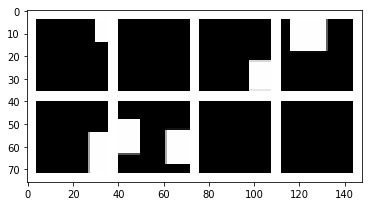

In [13]:
x_mu,c,dxdy,cxcy = vae.model()
#print(dxdy)
show_batch(x_mu, nrow=4,npadding=4)
#print(c)

In [14]:
#synthetic_data_train = vae.generate_synthetic_data(N=500)
#synthetic_data_test = vae.generate_synthetic_data(N=10)
#save_obj(synthetic_data_train,"synthetic_data_train_v4")    
#save_obj(synthetic_data_test,"synthetic_data_test_v4")    

### Test the parts of the generator

torch.Size([16, 1, 32, 32])


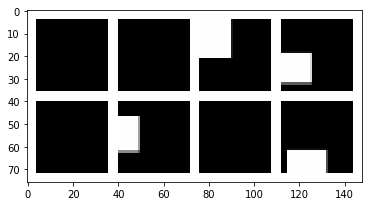

In [15]:
# Show input images
imgs_in=trainloader.load(CHANNELS=1)
show_batch(imgs_in[0:8], nrow=4,npadding=4)
print(imgs_in.shape)

torch.Size([8, 1, 32, 32])
tensor(1., grad_fn=<SumBackward0>)
tensor(0.9597)
tensor(1.0581)


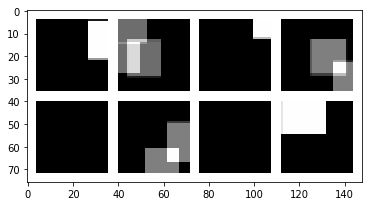

In [16]:
# generate picture according to prior
x_mu,c,dxdy,cxcy = vae.model(imgs=None)
print(x_mu.shape)
show_batch(x_mu,nrow=4,npadding=4)

print(torch.sum(c[0,:,0]))
print(torch.mean(dxdy[0,:,0]))
print(torch.mean(dxdy[0,:,1]))
#print(dxdy[0,:,:])

### DEBUG

In [17]:
import pyro.poutine as poutine
print("----MODEL ---------")
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

print("----GUIDE ---------")
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

----MODEL ---------
 Trace Shapes:         
  Param Sites:         
 Sample Sites:         
    batch dist   |     
         value 8 |     
      log_prob   |     
 latent_z dist 8 | 4 50
         value 8 | 4 50
      log_prob 8 |     
center_bb dist 8 | 4  2
         value 8 | 4  2
      log_prob 8 |     
  size_bb dist 8 | 4  2
         value 8 | 4  2
      log_prob 8 |     
  n_boxes dist   |     
         value 4 |     
      log_prob   |     
      c_0 dist 8 |     
         value 8 |     
      log_prob 8 |     
      c_1 dist 8 |     
         value 8 |     
      log_prob 8 |     
      c_2 dist 8 |     
         value 8 |     
      log_prob 8 |     
      c_3 dist 8 |     
         value 8 |     
      log_prob 8 |     
----GUIDE ---------
                                       Trace Shapes:                   
                                        Param Sites:                   
            inference$$$0.cnn.0.double_conv.0.weight   8   1 3   3     
            inference$$$

### RUN THE INFERENCE

In [18]:
#vae
# setup the optimizer
adam_args = {"lr": 1.0e-4}
optimizer = Adamax(adam_args)
#sgd_params = {"lr": 1.0e-4}
#optimizer = SGD(sgd_params)

# setup the Variational Inference 
svi = SVI(vae.model, vae.guide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))

train_loss_history = list()
test_loss_history = list()
min_test_loss = 999999

In [19]:
# Save the parameters beofre starting
save_obj(params,"params_model_SQUARE_v2")

# load saved model
#load_model(vae,"compositional_vae_v2_0")

# training loop
TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = vae.train_one_epoch(svi, trainloader, desired_channels=1, verbose=(epoch == 0))
    train_loss_history.append(total_epoch_loss_train)
    print("[epoch %03d] average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if((epoch % TEST_FREQUENCY) == 0):
        # report test diagnostics
        total_epoch_loss_test = vae.evaluate_one_epoch(svi, testloader, desired_channels=1, verbose=(epoch == 0))
        test_loss_history.append(total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))
        
        # Save if you got a new record
        if(test_loss_history[-1] < min_test_loss):
            print("New record!")
            min_test_loss = test_loss_history[-1]
            save_model(vae,"compositional_vae_v3_"+str(epoch))       
            save_obj(test_loss_history,"test_elbo_history_v3_"+str(epoch))
            save_obj(train_loss_history,"train_elbo_history_v3_"+str(epoch))
            #save_obj(params,"params_v1_",+str(epoch))
            
    if((epoch % 20) == 0):
        save_model(vae,"compositional_vae_v3_"+str(epoch))       
        save_obj(test_loss_history,"test_loss_history_v3_"+str(epoch))
        save_obj(train_loss_history,"train_loss_history_v3_"+str(epoch))

i=   0 train_loss=22682.77115
i=   1 train_loss=17995.15929
i=   2 train_loss=18137.59307
i=   3 train_loss=20289.50101
i=   4 train_loss=14881.73544
i=   5 train_loss=16804.86028
i=   6 train_loss=13296.22499
i=   7 train_loss=13597.25716
i=   8 train_loss=14098.80969
i=   9 train_loss=14641.83242


KeyboardInterrupt: 

## SAVE EVERYTHING

In [ ]:
save_model(vae,"cVAE_square_final_MODEL_v2") 
save_obj(params,"cVAE_square_final_PARAMS_v2")
save_obj(train_loss_history ,"cVAE_square_final_TRAINLOSS_v2")
save_obj(test_loss_history ,"cVAE_square_final_TESTLOSS_v2")